# VAE on MNIST

In this notebook, a VAE will be trained on the MNIST dataset. At the end, a GUI illustrates the connection between the 2D latent space and the decoder reconstructions.

## Imports and parameters for loading and saving model

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
from utils.loaders import load_mnist, load_model
from models.VAE import VariationalAutoencoder

In [8]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))      # directory for storing visualization of network architecture
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))   # directory for storing digit images
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))  # directory for storing VAE weights

# mode =  'build' 
mode = 'load' 

## Load MNIST dataset

In [9]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## Build network

In [10]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [11]:
vae.encoder.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_8[0][0]              
____________________________________________________________________________________________

In [ ]:
vae.decoder.summary()

## Train the network

In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000  # weighting between the RMSE and KL divergence losses

vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

BATCH_SIZE = 32
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

## Reconstruct some of the original paintings

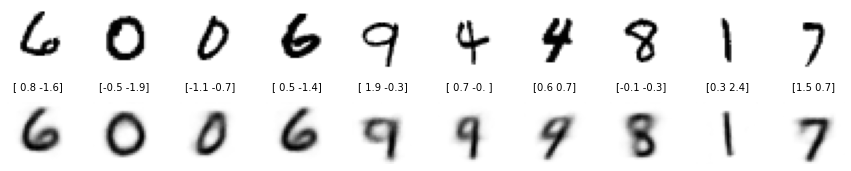

In [12]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

## Visualize latent space

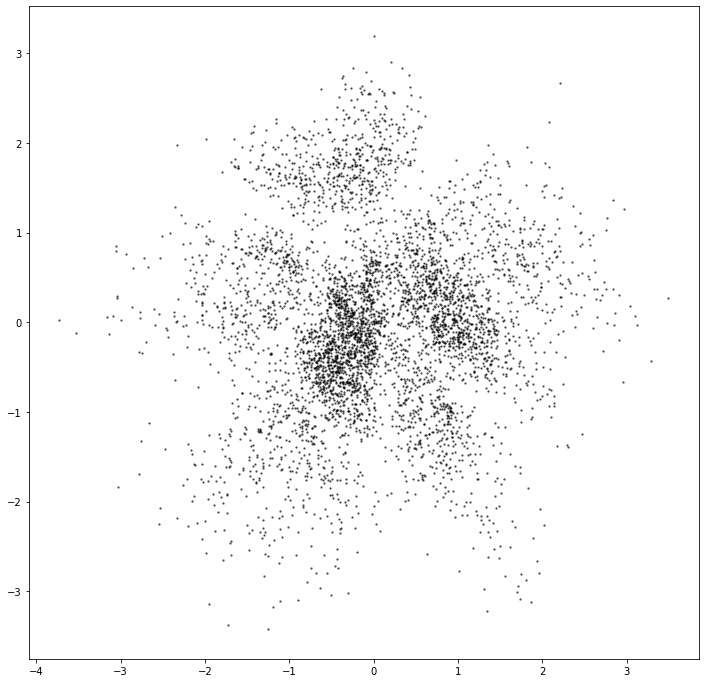

In [13]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

## Latent space - Reconstruction GUI

In [15]:
from matplotlib.widgets import Slider
%matplotlib qt

# Some constants
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15
valsteps = 0.05  # slider steps

# Pick some digits to plot in the latent space
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

# Compute the encoded digits
z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

# Initial coordinates
slider_x_init = 0.5  # inital values (both sliders go from 0 to 1)
slider_y_init = 0.5

# Plotting
#fig = plt.figure()
fig = plt.figure(figsize=(fig_width, fig_height))
plt.subplots_adjust(bottom=0.25)

# Left subplot
ax = fig.add_subplot(1, 2, 1)
ax.axis("equal")
left_plot = ax
plot_1 = left_plot.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)
plt.colorbar(plot_1)

# Plot the big red cross
cross = ax.scatter(slider_x_init, slider_y_init, s=100, c="r", marker="X")

# Right subplot
ax = fig.add_subplot(1, 2, 2)
right_plot = ax
right_plot.axis("equal")
right_plot.axis("off")

# Store the current reconstruction
z = np.array(list(zip([slider_x_init], [slider_y_init])))
reconstructed = vae.decoder.predict(z).squeeze()
plt.imshow(reconstructed, cmap=plt.cm.binary)

# Create x slider
# parameters list: xposition, yposition, width and height
ax_x_slide = plt.axes([0.135, 0.08, 0.26, 0.03])
x_slider = Slider(ax_x_slide, 'x', 0, 1, valinit=slider_x_init, valstep=valsteps)

# Create y slider
ax_y_slide = plt.axes([0.06, 0.3, 0.015, 0.52])
y_slider = Slider(ax_y_slide, 'y', 0, 1, valinit=slider_x_init, valstep=valsteps, orientation="vertical")

# Updating the plot
def update(val):
    global cross
    
    # Read slider values
    current_x = x_slider.val
    current_y = y_slider.val
    
    cross.remove()
    cross = left_plot.scatter(current_x, current_y, s=100, c="r", marker="X")
    
    # Compute reconstruction
    z = np.array(list(zip([current_x], [current_y])))
    reconstructed = vae.decoder.predict(z).squeeze()
    right_plot.imshow(reconstructed, cmap=plt.cm.binary)
    
    #fig.canvas.draw()
    
# Calling the function "update" when the value of the slider is changed
x_slider.on_changed(update)
y_slider.on_changed(update)
plt.show()